# 

# BGC Argo
Chloe Cheng

Opening Argo data downloaded from https://fleetmonitoring.euro-argo.eu/float/6902909. To download: click the NetCDF download button under 'Stations Data' and enter email. In my experience, the link took a few days to arrive.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [60]:
ds = xr.open_dataset('/Users/chloecheng/Documents/Stanford-SEA/bgc_argo/GL_PR_PF_6902909.nc')
ds

<xarray.Dataset>
Dimensions:                   (TIME: 1501, LATITUDE: 1501, LONGITUDE: 1501,
                               POSITION: 1501, DEPTH: 1932)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 2019-03-01T05:30:00 ... 2...
  * LATITUDE                  (LATITUDE) float32 -8.85 -8.85 ... -8.167 -8.167
  * LONGITUDE                 (LONGITUDE) float32 -140.6 -140.6 ... -142.2
Dimensions without coordinates: POSITION, DEPTH
Data variables: (12/46)
    TIME_QC                   (TIME) float32 ...
    POSITION_QC               (POSITION) float32 ...
    DC_REFERENCE              (TIME) object ...
    DIRECTION                 (TIME) object ...
    VERTICAL_SAMPLING_SCHEME  (TIME) object ...
    PRES                      (TIME, DEPTH) float32 ...
    ...                        ...
    DOWN_IRRADIANCE412        (TIME, DEPTH) float64 ...
    DOWN_IRRADIANCE412_QC     (TIME, DEPTH) float32 ...
    DOWN_IRRADIANCE490        (TIME, DEPTH) float64 ...
    DOWN_IRRADIANCE490_QC     (TIME, DEPTH) float32 ...
    LGHT                      (TIME, DEPTH) float64 ...
    LGHT_QC                   (TIME, DEPTH) float32 ...
Attributes: (12/49)
    data_type:                      OceanSITES vertical profile
    format_version:                 1.4
    platform_code:                  6902909
    institution:                    Laboratory of Oceanography of Villefranche
    institution_edmo_code:          490
    site_code:                       
    ...                             ...
    last_date_observation:          2024-04-09T01:46:00Z
    last_latitude_observation:      -8.16725
    last_longitude_observation:     -142.24309
    date_update:                    2024-04-19T06:49:52Z
    history:                        2024-04-19T06:49:52Z : Creation
    data_mode:                      M

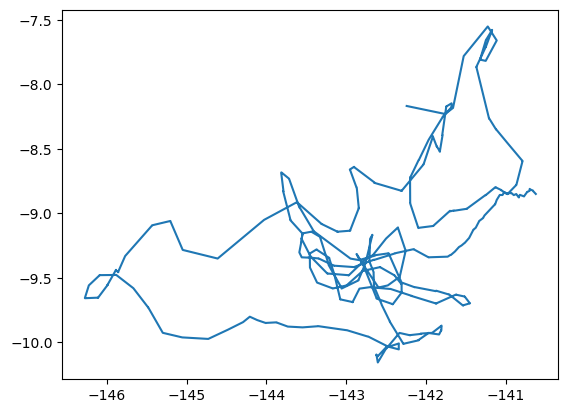

In [61]:
plt.plot(ds.LONGITUDE, ds.LATITUDE);

## Cleaning

The original dataset contains a lot of nans, so here we clean it by dropping data where every chlorophyll arrays where every time value is nan.

In [131]:
ds_clean = ds.dropna(dim='TIME', how='all', subset=['CPHL'])  # there are a lot of only-NaN times we need to drop
ds_clean

<xarray.Dataset>
Dimensions:                   (TIME: 218, LATITUDE: 1501, LONGITUDE: 1501,
                               POSITION: 1501, DEPTH: 1932)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 2019-03-01T05:30:00 ... 2...
  * LATITUDE                  (LATITUDE) float32 -8.85 -8.85 ... -8.167 -8.167
  * LONGITUDE                 (LONGITUDE) float32 -140.6 -140.6 ... -142.2
Dimensions without coordinates: POSITION, DEPTH
Data variables: (12/46)
    TIME_QC                   (TIME) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    POSITION_QC               (POSITION) float32 ...
    DC_REFERENCE              (TIME) object b'63729209' ... b'93572435'
    DIRECTION                 (TIME) object b'D' b'A' b'D' ... b'A' b'A' b'A'
    VERTICAL_SAMPLING_SCHEME  (TIME) object b'Secondary sampling: discrete [1...
    PRES                      (TIME, DEPTH) float32 4.1 4.6 5.9 ... nan nan nan
    ...                        ...
    DOWN_IRRADIANCE412        (TIME, DEPTH) float64 nan nan nan ... nan nan nan
    DOWN_IRRADIANCE412_QC     (TIME, DEPTH) float32 nan nan nan ... nan nan nan
    DOWN_IRRADIANCE490        (TIME, DEPTH) float64 nan nan nan ... nan nan nan
    DOWN_IRRADIANCE490_QC     (TIME, DEPTH) float32 nan nan nan ... nan nan nan
    LGHT                      (TIME, DEPTH) float64 nan nan nan ... nan nan nan
    LGHT_QC                   (TIME, DEPTH) float32 nan nan nan ... nan nan nan
Attributes: (12/49)
    data_type:                      OceanSITES vertical profile
    format_version:                 1.4
    platform_code:                  6902909
    institution:                    Laboratory of Oceanography of Villefranche
    institution_edmo_code:          490
    site_code:                       
    ...                             ...
    last_date_observation:          2024-04-09T01:46:00Z
    last_latitude_observation:      -8.16725
    last_longitude_observation:     -142.24309
    date_update:                    2024-04-19T06:49:52Z
    history:                        2024-04-19T06:49:52Z : Creation
    data_mode:                      M

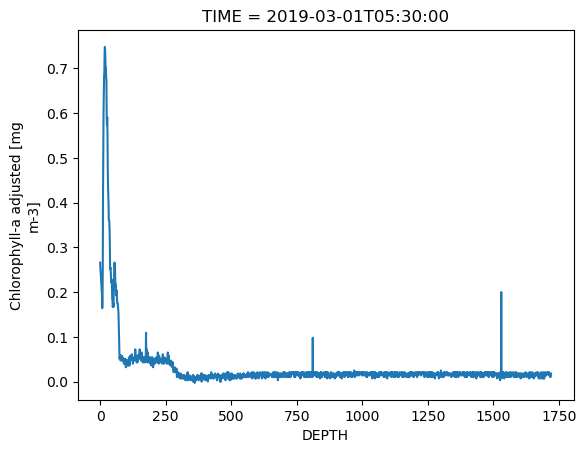

In [152]:
ds_clean.CPHL_ADJUSTED[0].plot()

## Deep Chlorphyll Max

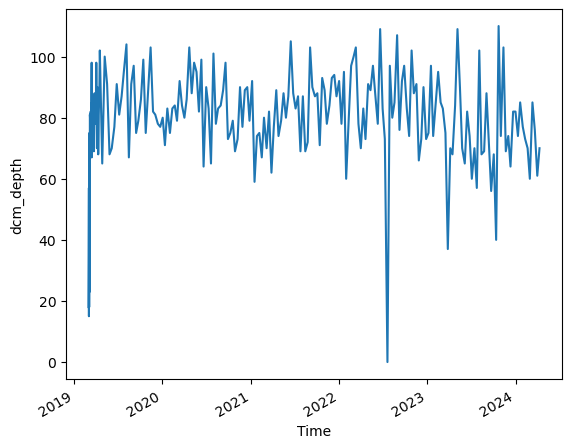

In [170]:
# Getting a quick DCM depth via argmax

dcm_index = ds_clean.CPHL_ADJUSTED.argmax(dim='DEPTH')
dcm_depth = ds_clean.DEPTH.isel(DEPTH=dcm_index)

ds_dcm_depth = xr.Dataset({'dcm_depth': dcm_depth})

ds_dcm = ds_clean.sel(DEPTH=dcm_depth)

ds_dcm = xr.merge([ds_dcm, ds_dcm_depth])
ds_dcm

ds_dcm.dcm_depth.plot()


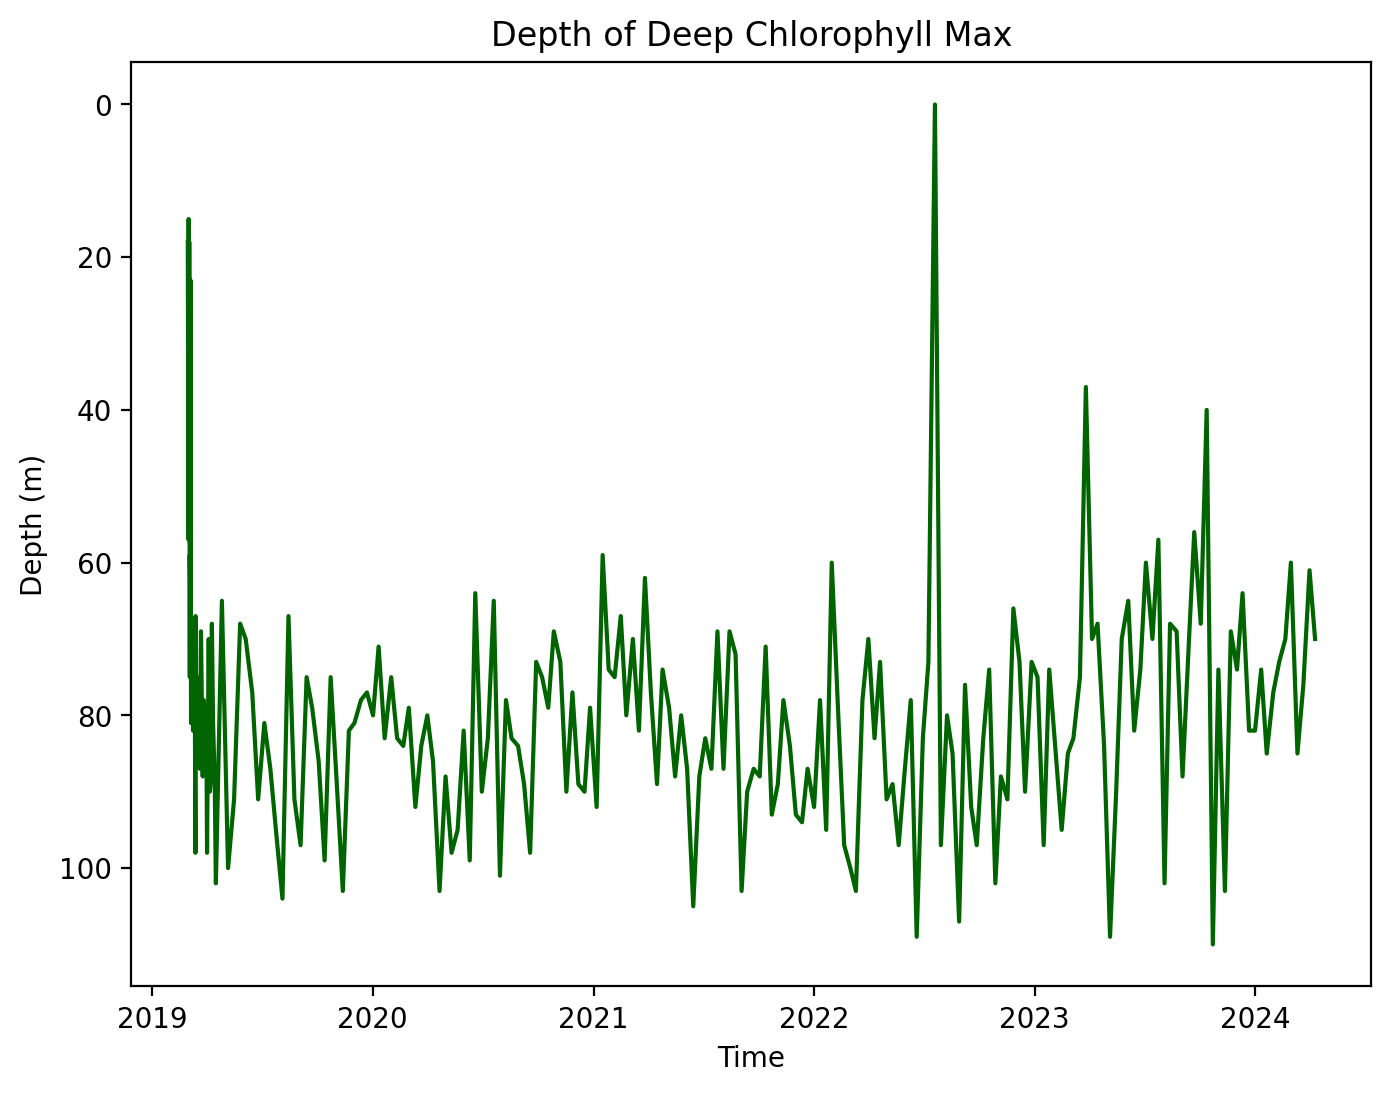

In [217]:
# Prettier plot

dcm_depth = ds_dcm.dcm_depth.values
dcm_time = ds_dcm.TIME.values

plt.figure(figsize=(8, 6), dpi=200)
plt.plot(dcm_time, dcm_depth, color='darkgreen')
plt.ylabel('Depth (m)')
plt.xlabel('Time')
plt.title('Depth of Deep Chlorophyll Max')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()


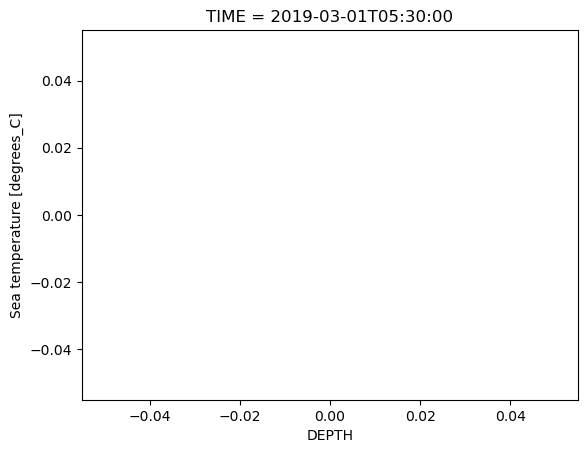

In [176]:
ds_clean.TEMP[0].plot()

In [195]:
ds_clean_temp = ds.dropna(dim='TIME', how='all', subset=['TEMP'])  # there are a lot of only-NaN times we need to drop
ds_clean_temp

<xarray.Dataset>
Dimensions:                   (TIME: 639, LATITUDE: 1501, LONGITUDE: 1501,
                               POSITION: 1501, DEPTH: 1932)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 2019-03-01T05:30:00 ... 2...
  * LATITUDE                  (LATITUDE) float32 -8.85 -8.85 ... -8.167 -8.167
  * LONGITUDE                 (LONGITUDE) float32 -140.6 -140.6 ... -142.2
Dimensions without coordinates: POSITION, DEPTH
Data variables: (12/46)
    TIME_QC                   (TIME) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    POSITION_QC               (POSITION) float32 8.0 8.0 8.0 8.0 ... 1.0 1.0 1.0
    DC_REFERENCE              (TIME) object b'63729206' ... b'93572432'
    DIRECTION                 (TIME) object b'D' b'A' b'A' ... b'D' b'A' b'A'
    VERTICAL_SAMPLING_SCHEME  (TIME) object b'Primary sampling: averaged [2se...
    PRES                      (TIME, DEPTH) float32 4.4 5.5 6.4 ... nan nan nan
    ...                        ...
    DOWN_IRRADIANCE412        (TIME, DEPTH) float64 nan nan nan ... nan nan nan
    DOWN_IRRADIANCE412_QC     (TIME, DEPTH) float32 nan nan nan ... nan nan nan
    DOWN_IRRADIANCE490        (TIME, DEPTH) float64 nan nan nan ... nan nan nan
    DOWN_IRRADIANCE490_QC     (TIME, DEPTH) float32 nan nan nan ... nan nan nan
    LGHT                      (TIME, DEPTH) float64 nan nan nan ... nan nan nan
    LGHT_QC                   (TIME, DEPTH) float32 nan nan nan ... nan nan nan
Attributes: (12/49)
    data_type:                      OceanSITES vertical profile
    format_version:                 1.4
    platform_code:                  6902909
    institution:                    Laboratory of Oceanography of Villefranche
    institution_edmo_code:          490
    site_code:                       
    ...                             ...
    last_date_observation:          2024-04-09T01:46:00Z
    last_latitude_observation:      -8.16725
    last_longitude_observation:     -142.24309
    date_update:                    2024-04-19T06:49:52Z
    history:                        2024-04-19T06:49:52Z : Creation
    data_mode:                      M

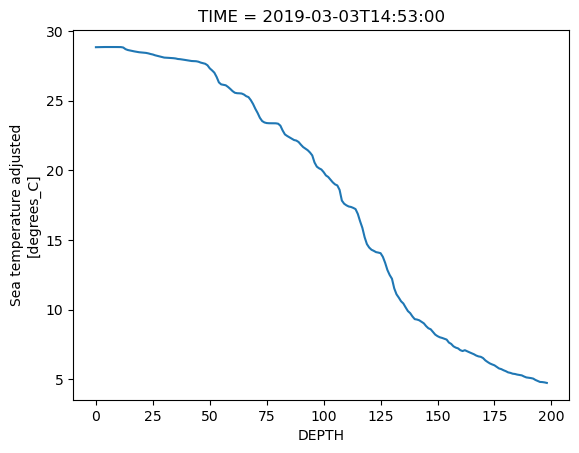

In [196]:
ds_clean_temp.TEMP_ADJUSTED[6].plot()